Импортируем необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier, IsolationForest

Определяем функции для работы с данными

In [ ]:
def data_type(data):
  num = data.select_dtypes([np.number]).columns.tolist()
  cat = data.select_dtypes('object').columns.tolist()
  return num, cat

def numeric_data_EDA(data):
  df_EDA = data.describe().T.drop(['count', '25%', '50%', '75%'], axis = 1)
  df_EDA['NAN_Percentage'] = 100 * data.isna().sum() / len(data)
  for col in data.columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    IQR = q3 - q1
    upper = q3 + 1.5 * IQR
    lower = q1 - 1.5 * IQR
    outliers_count = data.loc[(data[col] > upper)|(data[col] < lower), col].count()
    df_EDA.loc[col, 'Outliers_Percentage'] = (100 * outliers_count / len(data))
  df_EDA['skewness'] = data.skew()
  df_EDA['kurtosis'] = data.kurt()
  df_EDA.round(2)
  return df_EDA

def categorical_data_EDA(data):

  df_EDA = pd.concat([data.apply(lambda x: x.nunique()),
                      data.apply(lambda x: [x.unique()]).T,
                      data.apply(lambda x: x.mode()).T,
                      100 * data.isna().sum() / len(data)], axis = 1, sort=False)
  df_EDA.columns = ['unique', 'values', 'mode', 'NAN_Percentage']
  return df_EDA

def Fill_NA_LinReg(data, column, cols = None):
  if cols == None:
    cols = data.select_dtypes([np.number]).columns.tolist()
    cols.remove(column)
  data_tmp = data.dropna()
  data_tmp2 = data.fillna(data.mean())
  model = make_pipeline(StandardScaler(), LinearRegression())
  model.fit(data_tmp[cols], data_tmp[column])
  data.loc[data[data[column].isna()].index, column] = model.predict(data_tmp2[data[column].isna()][cols])

def outliers_LogReg(data):
  LOF = LocalOutlierFactor(novelty=True)
  LOF.fit(data)
  pred = LOF.predict(data)
  outlier_index = np.where(pred == -1)
  return data.drop(index = outlier_index[0])

def model_test(X,y):
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
  model_RFC = RandomForestClassifier(random_state = 42)
  model_RFC.fit(X_train, y_train)
  return model_RFC.score(X_test, y_test)

Загружаем данные

In [ ]:
df = pd.read_csv('winequalityN.csv')

Проводим исследовательский анализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [ ]:
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

Определяем категориальные и количественные признаки

In [ ]:
num, cat = data_type(df)

Исследуем категориальные признаки

In [ ]:
categorical_data_EDA(df[cat])

unique        values   mode  NAN_Percentage
type       2  [white, red]  white             0.0

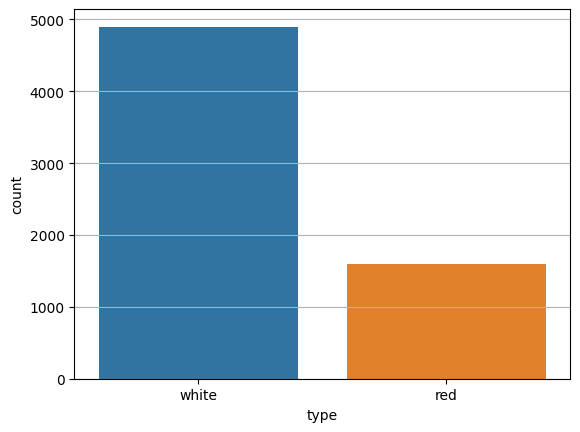

In [ ]:
sns.set_style({'axes.grid': True})
sns.countplot(x = 'type', data = df);

Исследуем количественные признаки

In [ ]:
round(numeric_data_EDA(df[num]), 2)

mean    std   min     max  NAN_Percentage  \
fixed acidity           7.22   1.30  3.80   15.90            0.15   
volatile acidity        0.34   0.16  0.08    1.58            0.12   
citric acid             0.32   0.15  0.00    1.66            0.05   
residual sugar          5.44   4.76  0.60   65.80            0.03   
chlorides               0.06   0.04  0.01    0.61            0.03   
free sulfur dioxide    30.53  17.75  1.00  289.00            0.00   
total sulfur dioxide  115.74  56.52  6.00  440.00            0.00   
density                 0.99   0.00  0.99    1.04            0.00   
pH                      3.22   0.16  2.72    4.01            0.14   
sulphates               0.53   0.15  0.22    2.00            0.06   
alcohol                10.49   1.19  8.00   14.90            0.00   
quality                 5.82   0.87  3.00    9.00            0.00   

                      Outliers_Percentage  skewness  kurtosis  
fixed acidity                        5.49      1.72      5.06  
volatile acidity                     5.79      1.50      2.83  
citric acid                          7.82      0.47      2.40  
residual sugar                       1.82      1.43      4.36  
chlorides                            4.40      5.40     50.89  
free sulfur dioxide                  0.95      1.22      7.91  
total sulfur dioxide                 0.15     -0.00     -0.37  
density                              0.05      0.50      6.61  
pH                                   1.12      0.39      0.37  
sulphates                            2.94      1.80      8.66  
alcohol                              0.05      0.57     -0.53  
quality                              3.51      0.19      0.23

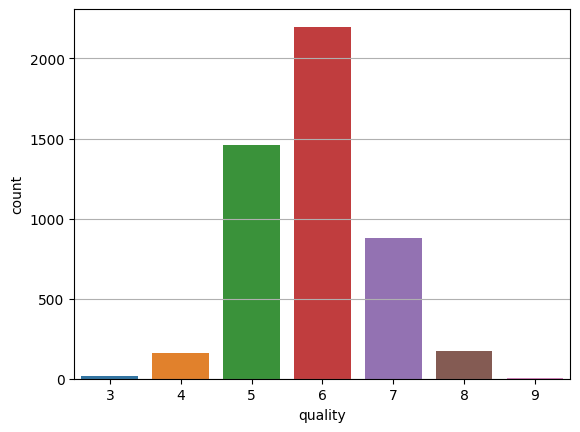

In [ ]:
sns.countplot(x = 'quality', data = df.loc[df['type'] == 'white']);

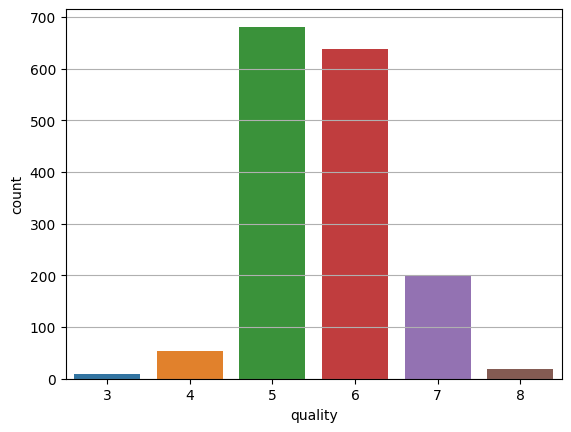

In [ ]:
sns.countplot(x = 'quality', data = df.loc[df['type'] == 'red']);

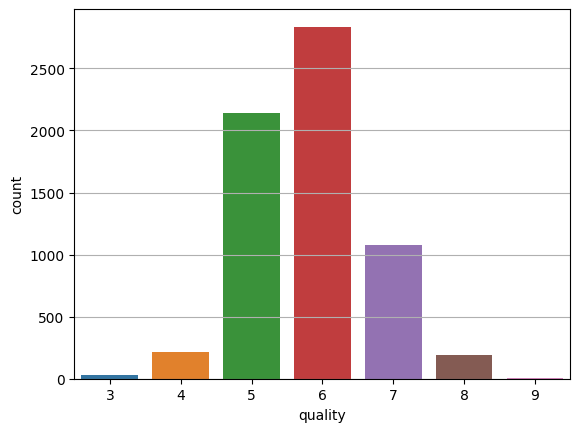

In [ ]:
sns.countplot(x = 'quality', data = df);

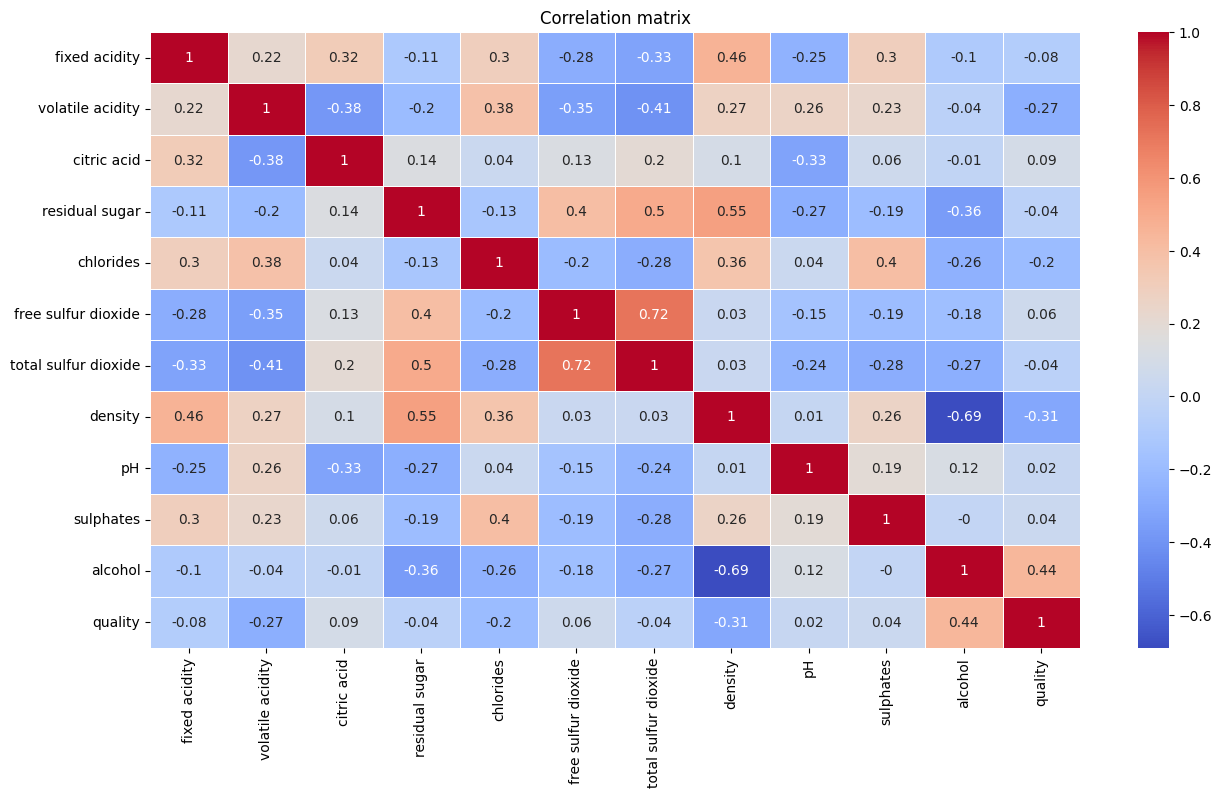

In [ ]:
plt.figure(figsize=(15,8))
data_corr = df[num].corr()
data_corr = np.round(data_corr, 2)
#data_corr[np.abs(data_corr) < 0.05] = 0
plt.grid(False)
sns.heatmap(data_corr, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix');

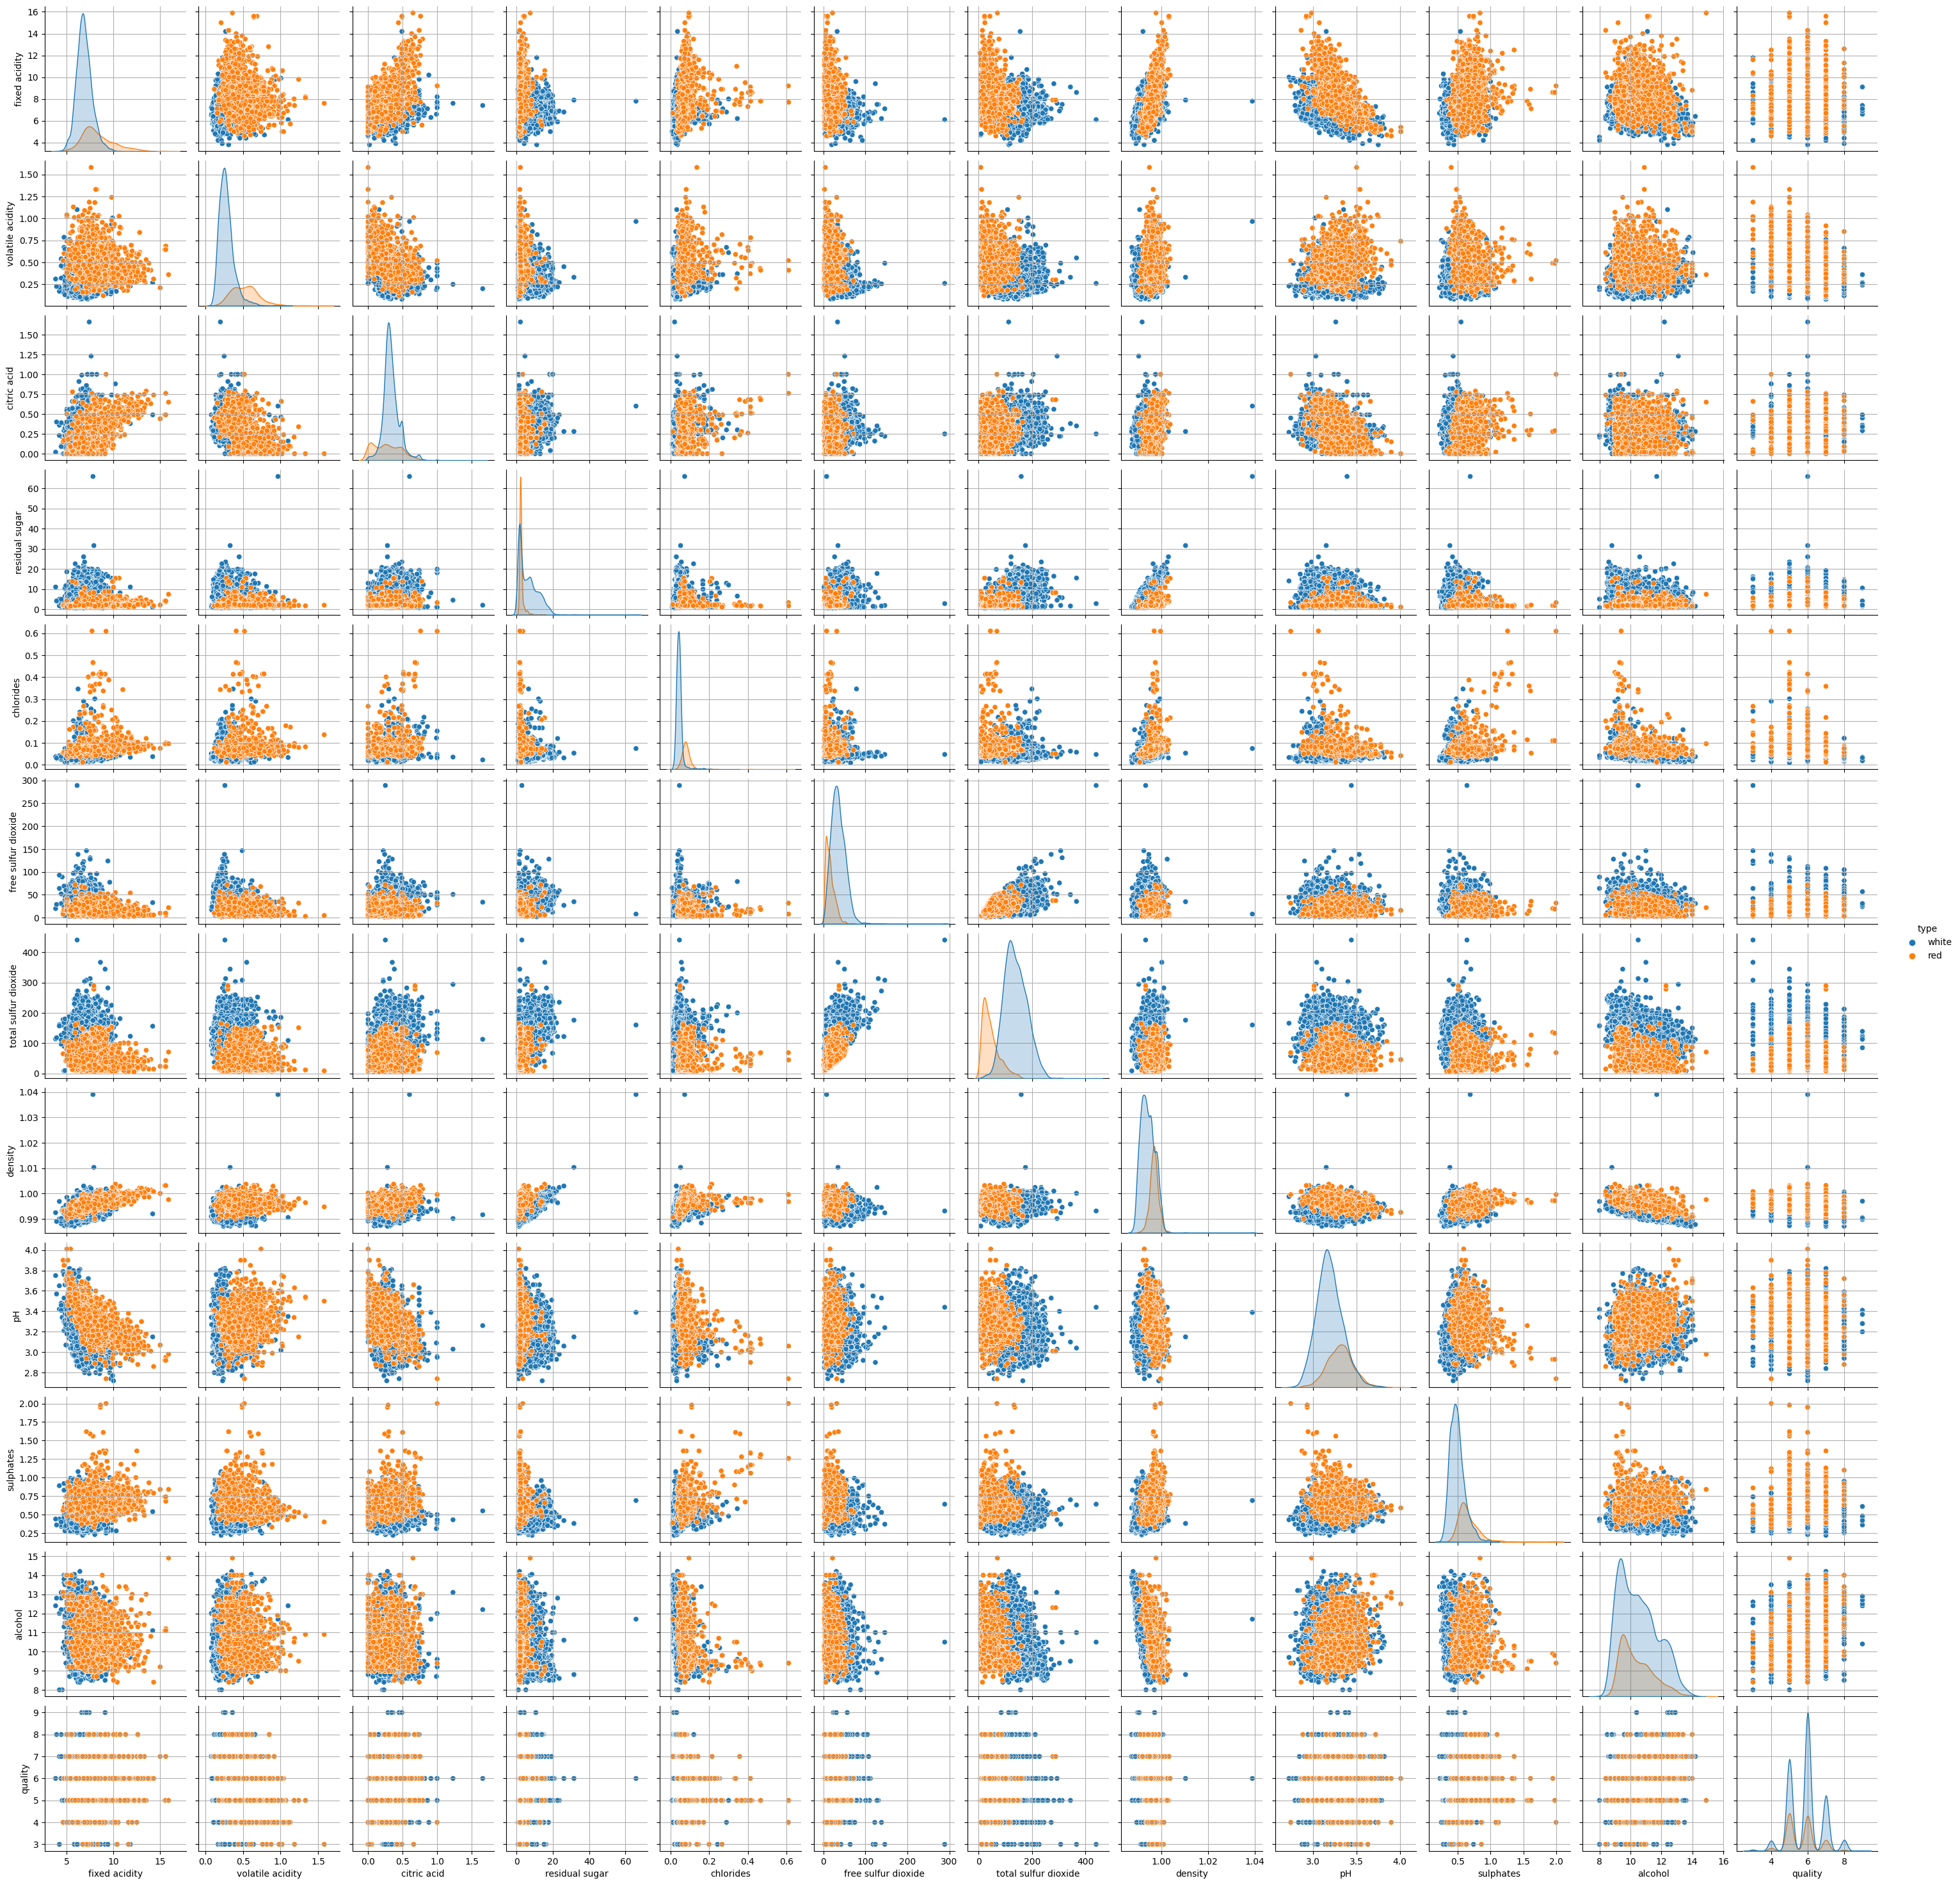

In [ ]:
sns.pairplot(df, hue = 'type');

Зависимость целевого переменной от признаков носит нелинейный характер, для прогнозирования будем использовать древесную модель RandomForestClassifier

Заполняем пропуски

In [ ]:
df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [ ]:
df_fillna = df.copy()
col_with_NA = df.columns[df.isna().any()].tolist()
for column in col_with_NA:
  Fill_NA_LinReg(df_fillna, column)

<ipython-input-35-722ccf02ee9c>:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_tmp2 = data.fillna(data.mean())
<ipython-input-35-722ccf02ee9c>:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_tmp2 = data.fillna(data.mean())
<ipython-input-35-722ccf02ee9c>:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence 

In [ ]:
df_fillna.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
df_white = df_fillna.loc[df_fillna['type'] == 'white'].drop('type', axis = 1).copy().reset_index(drop = True)
df_red = df_fillna.loc[df_fillna['type'] == 'red'].drop('type', axis = 1).copy().reset_index(drop = True)

Исследуем данные на наличие выбросов и удаляем их

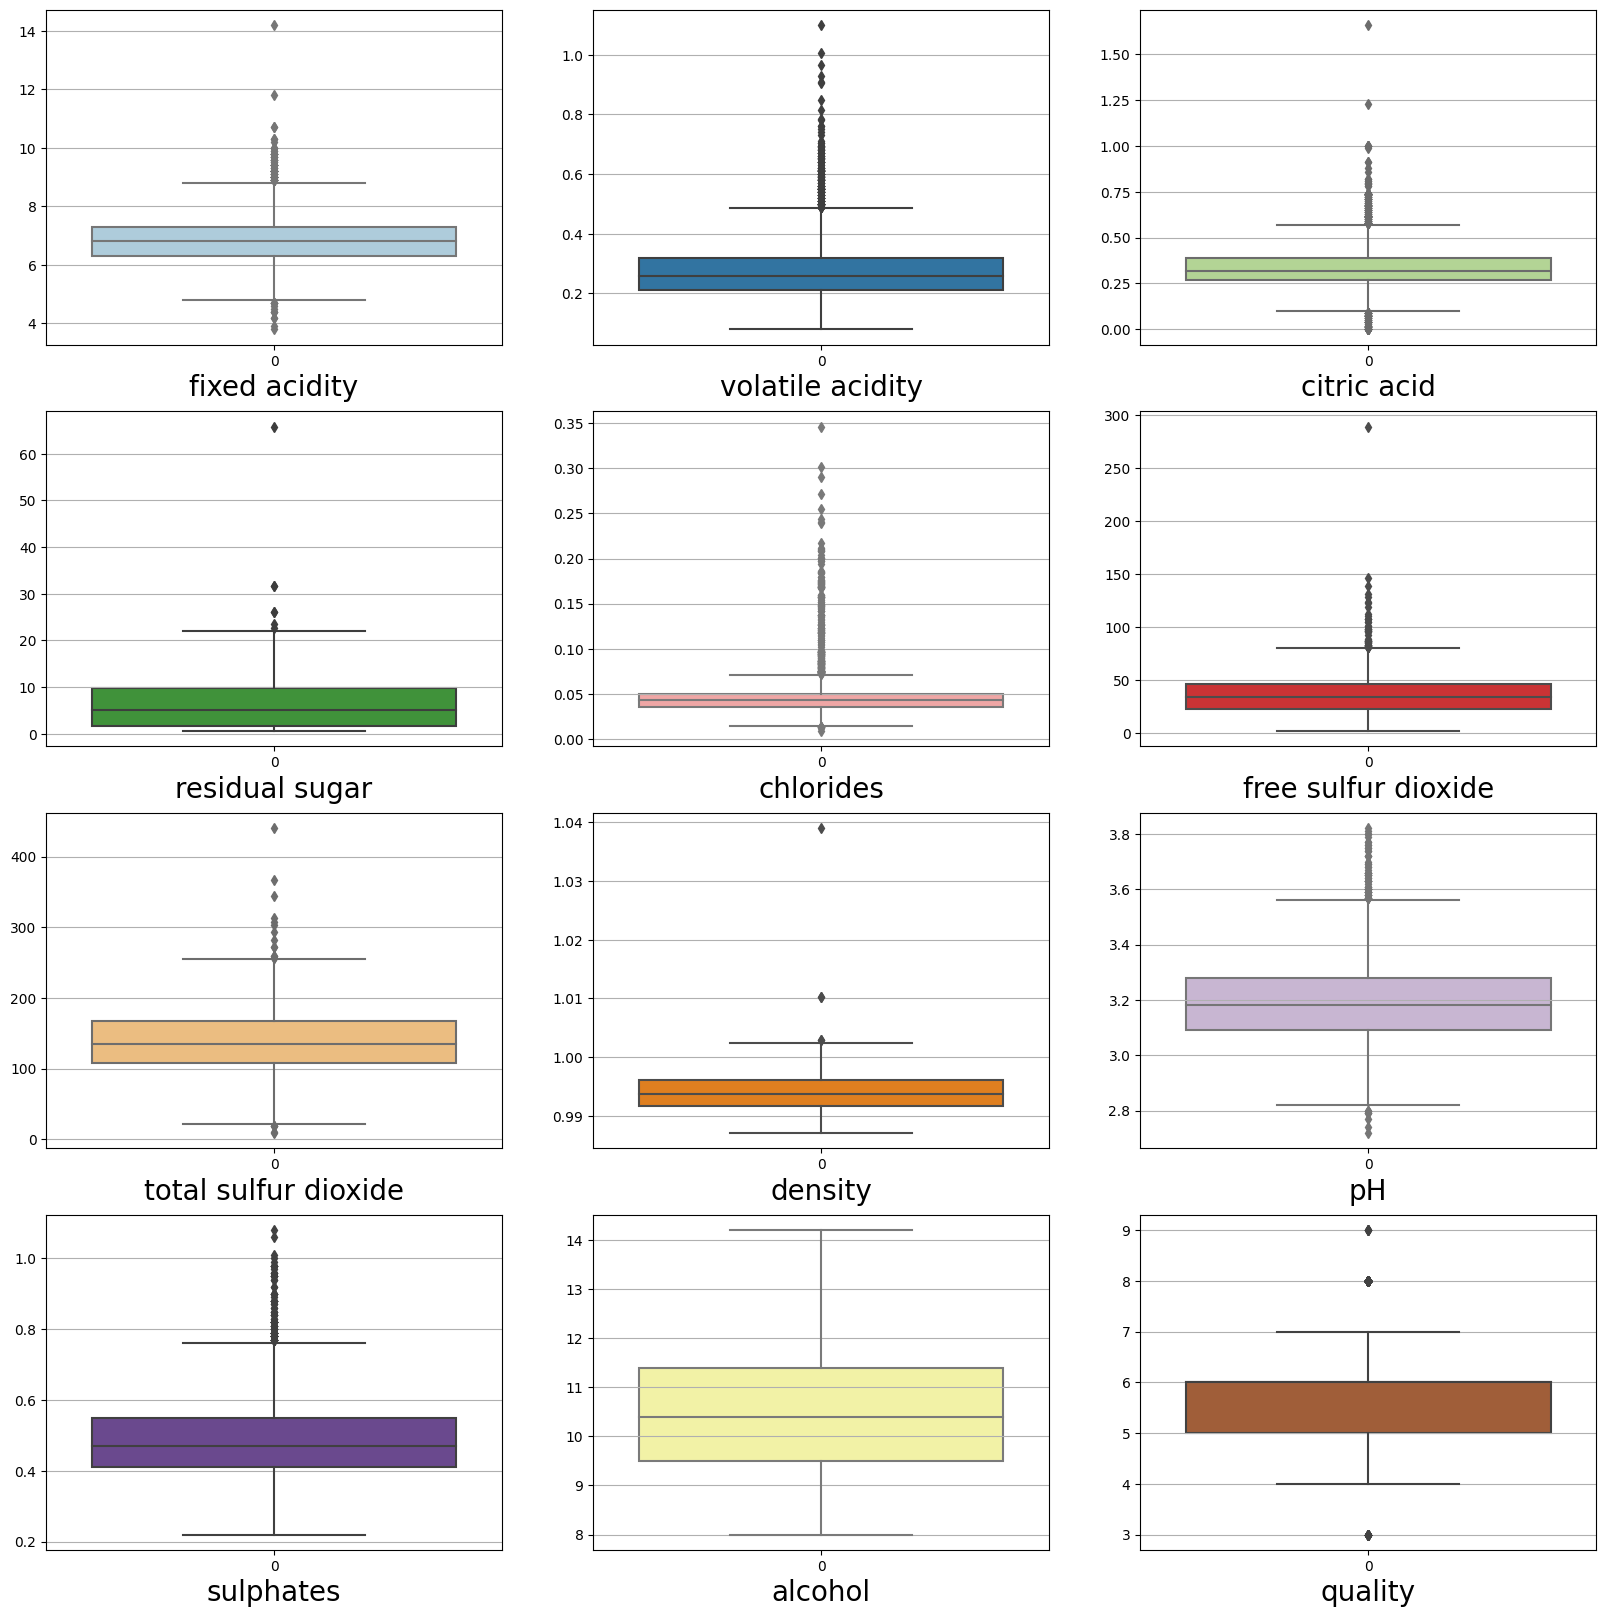

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
col = 0
data = df_white
for i in range(4):
  for j in range(3):
    sns.boxplot(data[data.columns[col]], ax=axs[i, j], color = cm.Paired(col))
    axs[i, j].set_xlabel(data.columns[col], fontsize = 20)
    col += 1

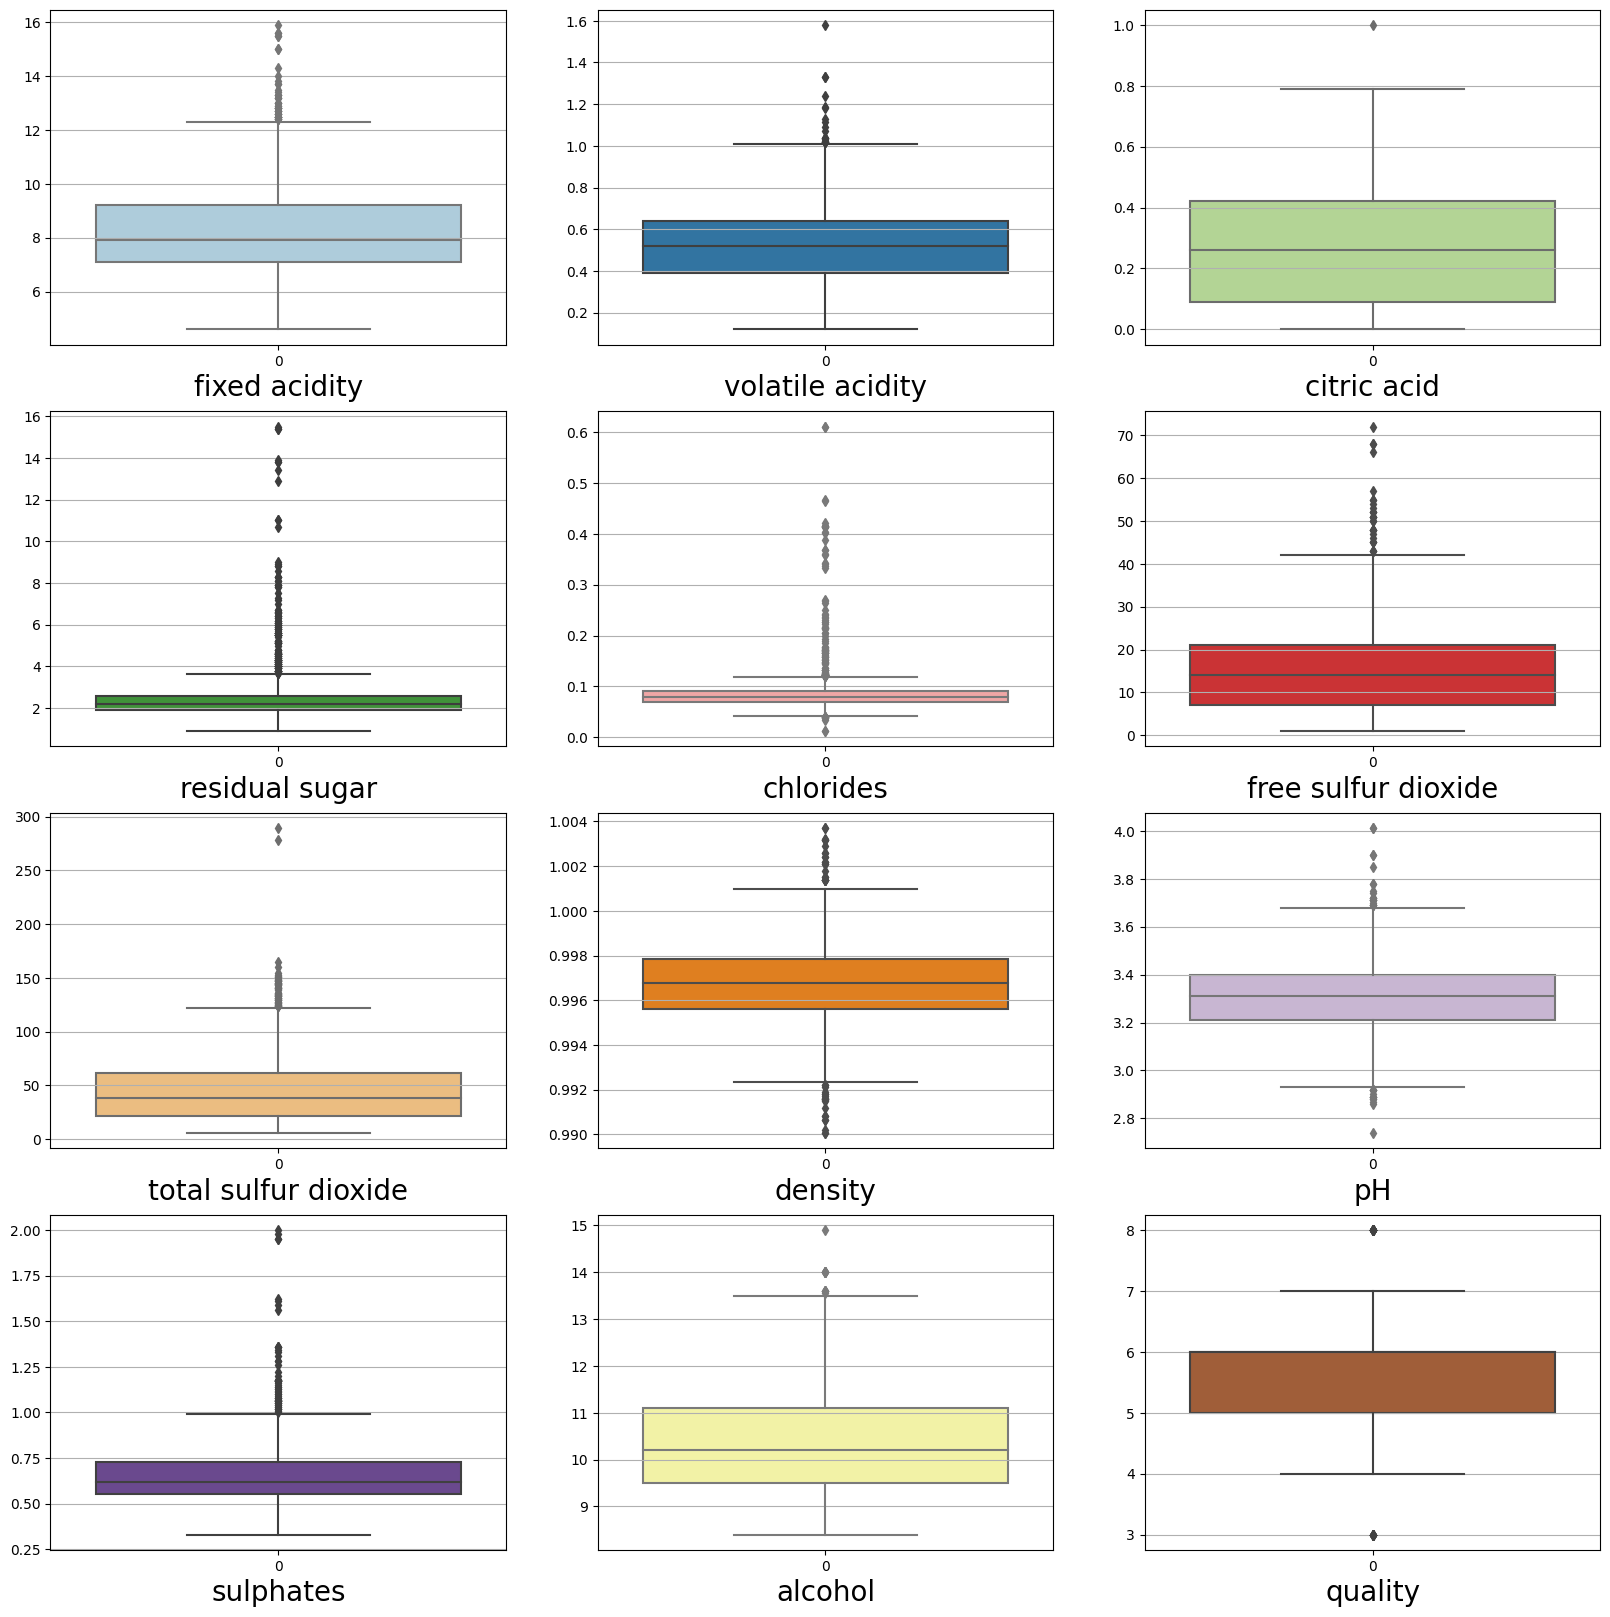

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
col = 0
data = df_red
for i in range(4):
  for j in range(3):
    sns.boxplot(data[data.columns[col]], ax=axs[i, j], color = cm.Paired(col))
    axs[i, j].set_xlabel(data.columns[col], fontsize = 20)
    col += 1

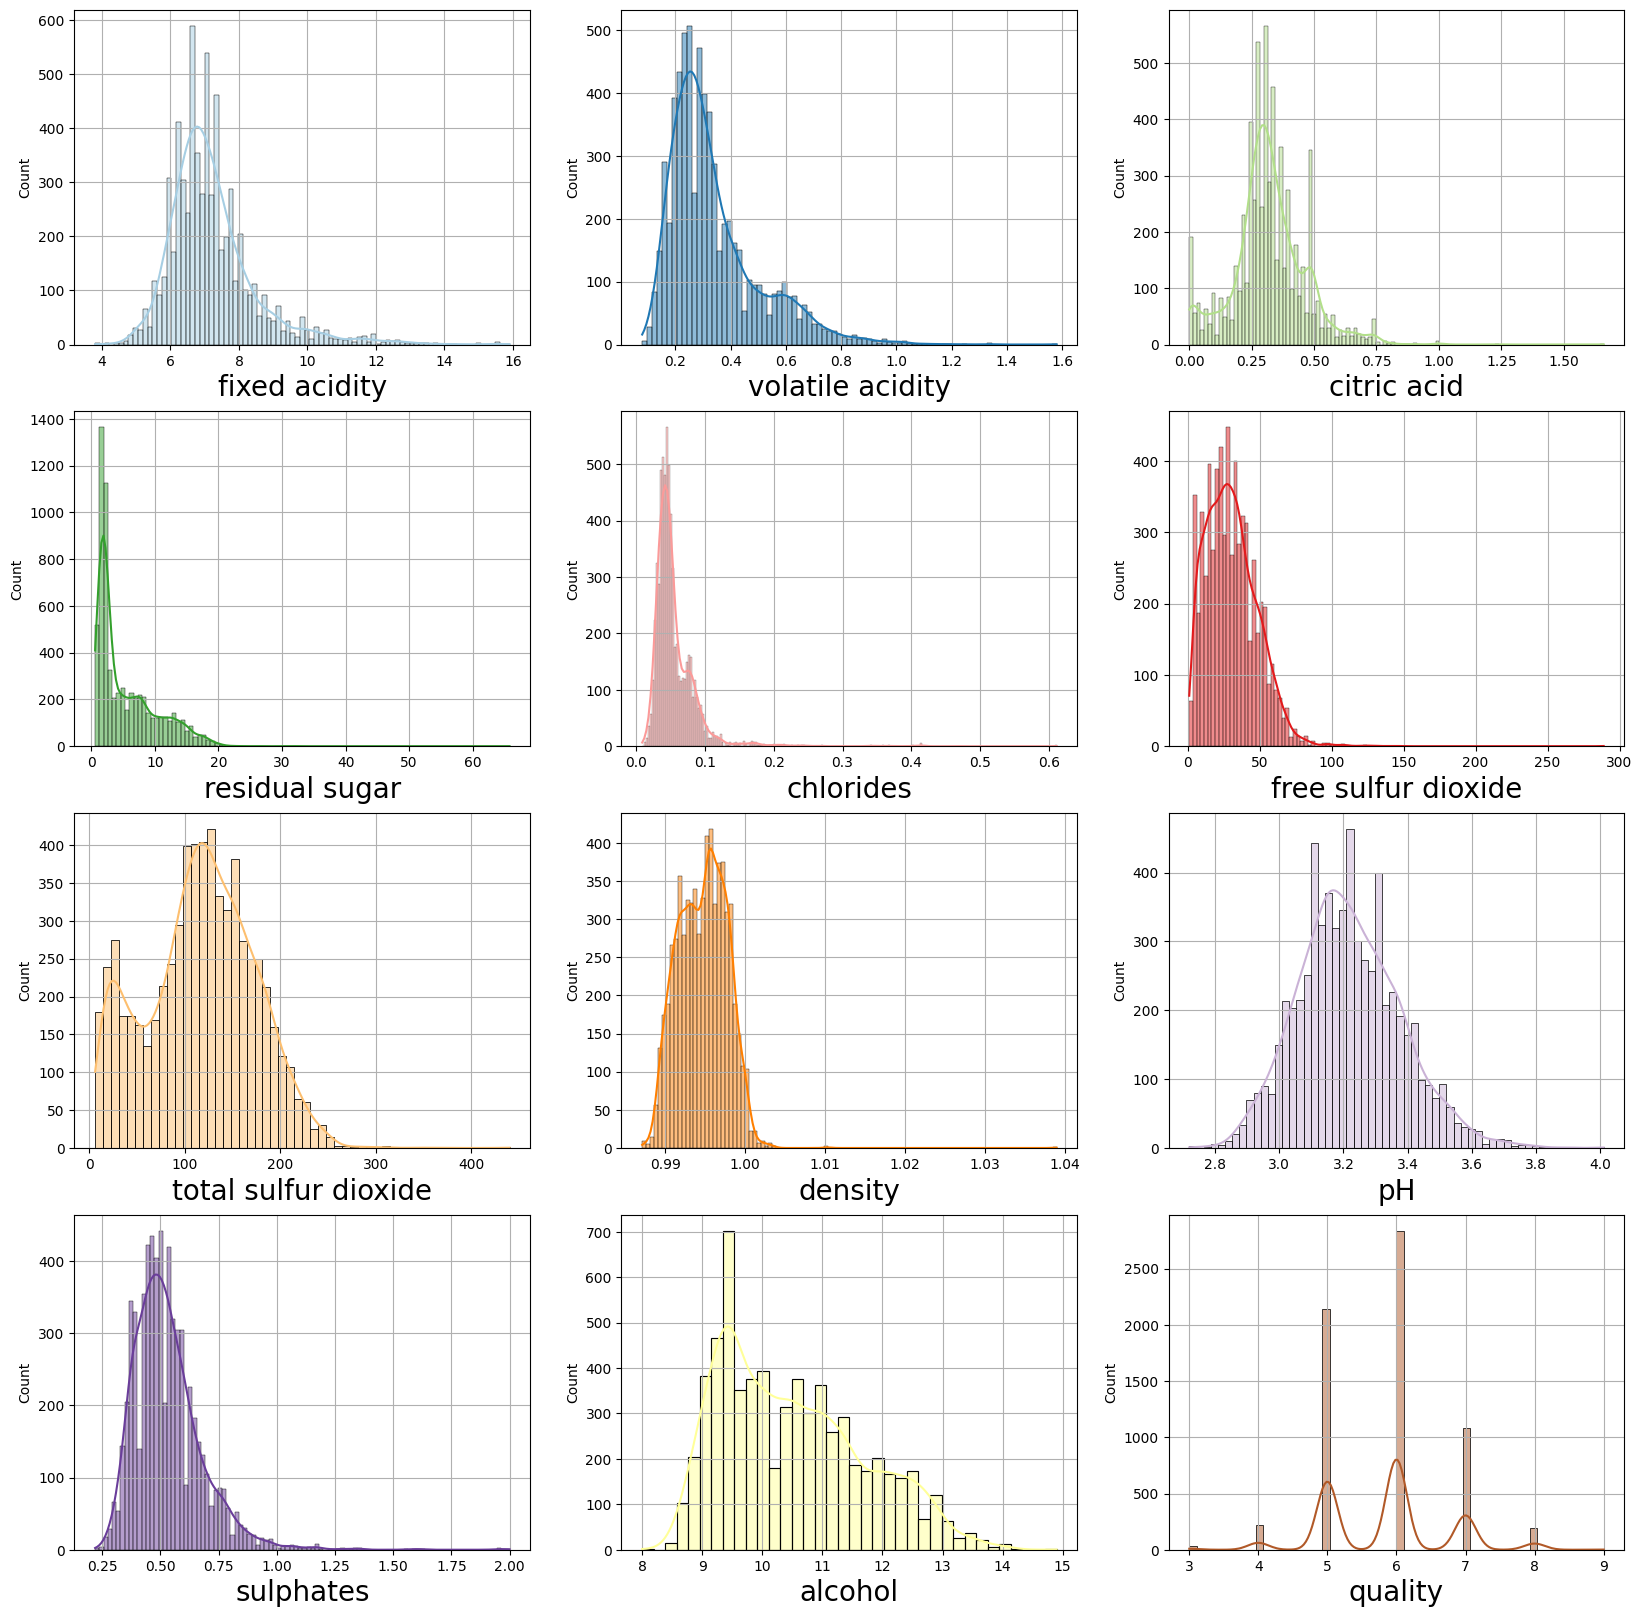

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
data = df_fillna.drop('type', axis = 1)
col = 0
for i in range(4):
  for j in range(3):
    sns.histplot(data[data.columns[col]], kde = True, ax = axs[i, j], color = cm.Paired(col))
    axs[i, j].set_xlabel(data.columns[col], fontsize = 20)
    col += 1

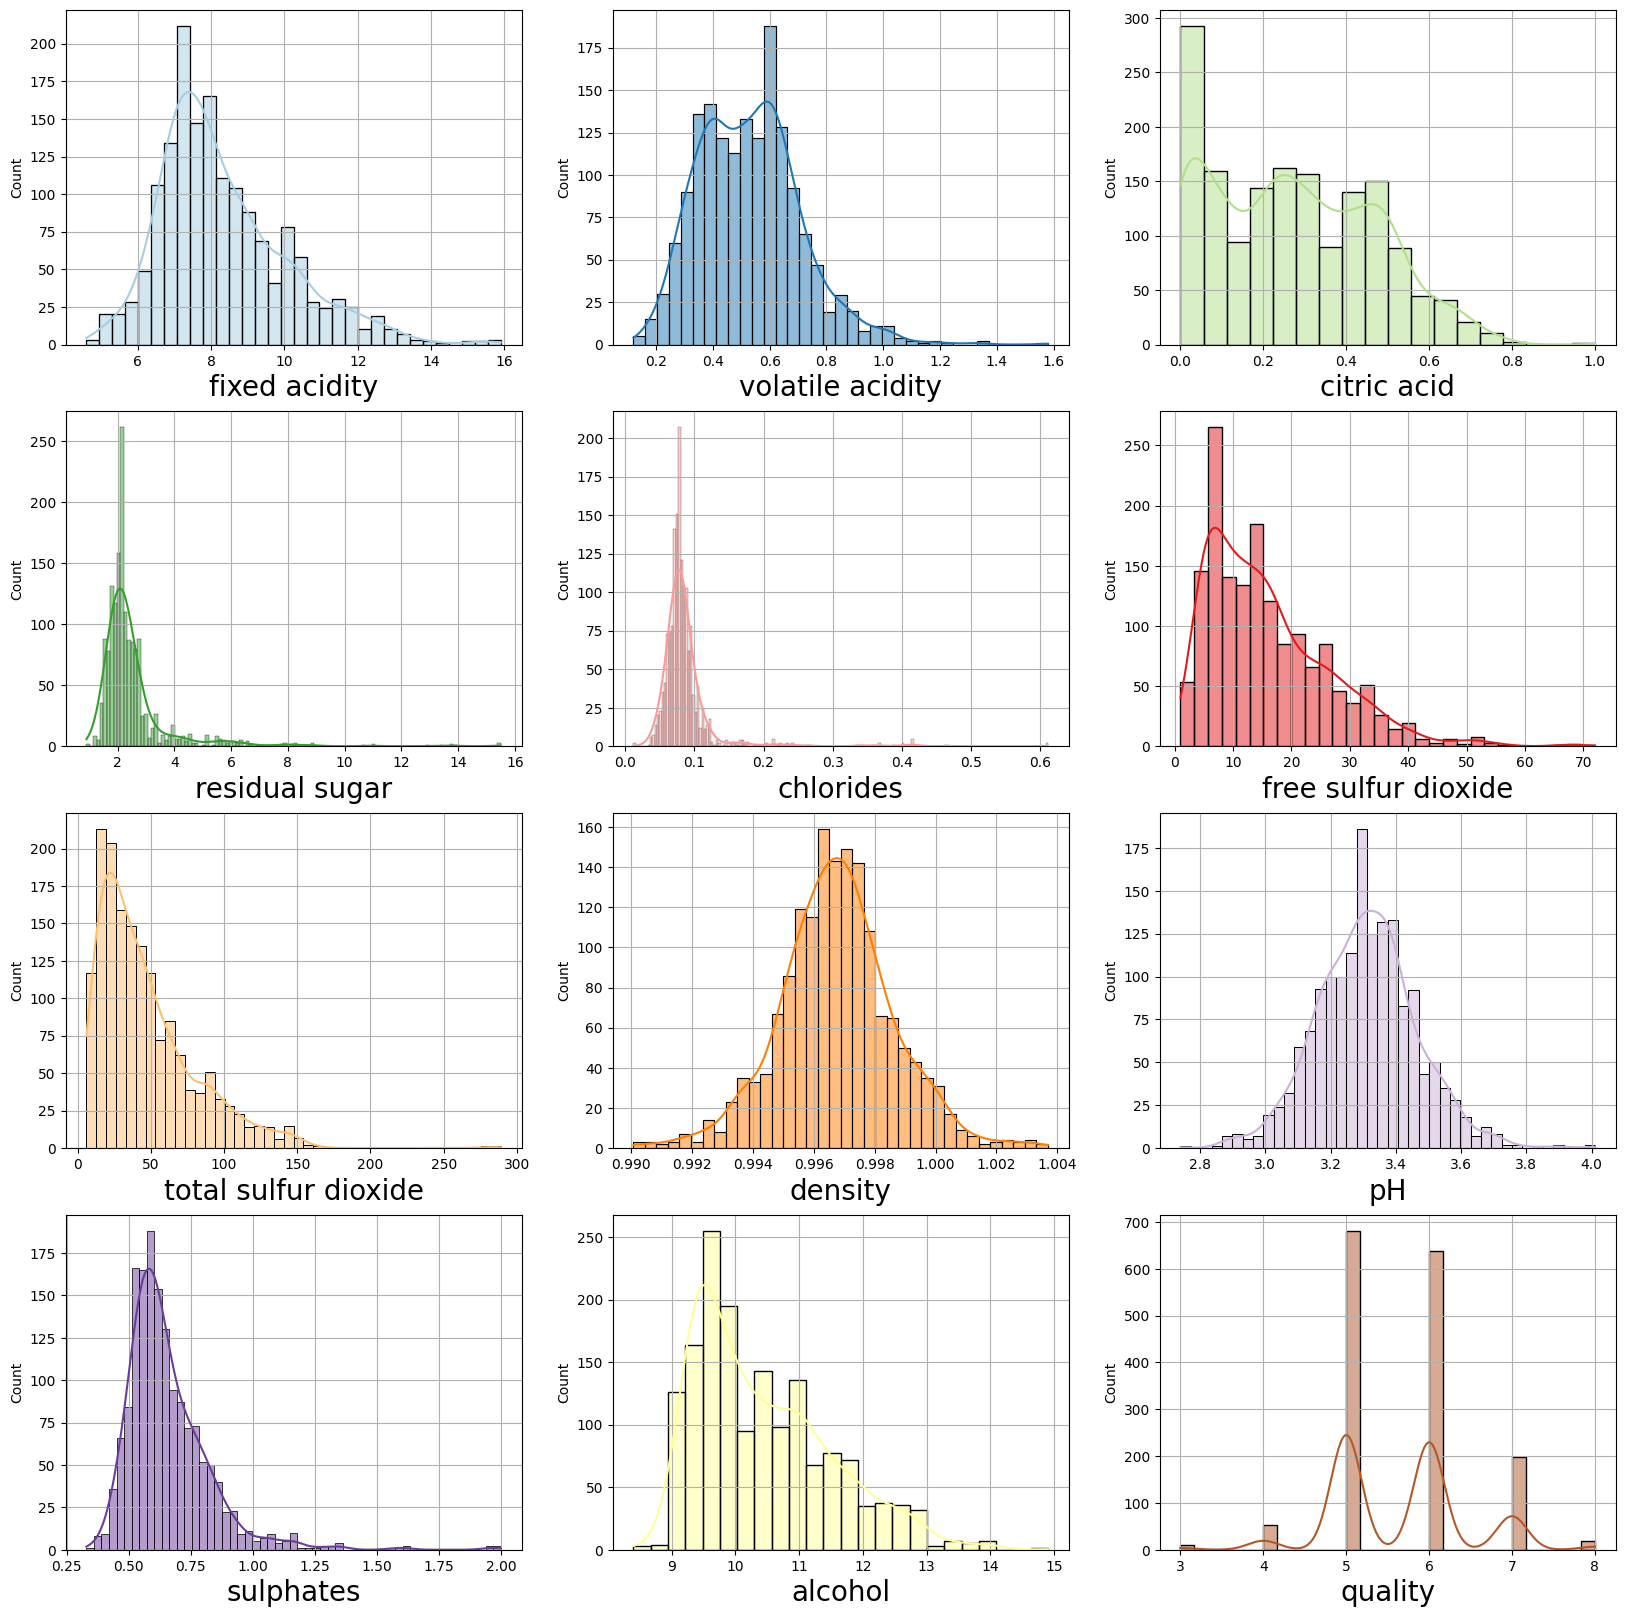

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
data = df_red
col = 0
for i in range(4):
  for j in range(3):
    sns.histplot(data[data.columns[col]], kde = True, ax = axs[i, j], color = cm.Paired(col))
    axs[i, j].set_xlabel(data.columns[col], fontsize = 20)
    col += 1

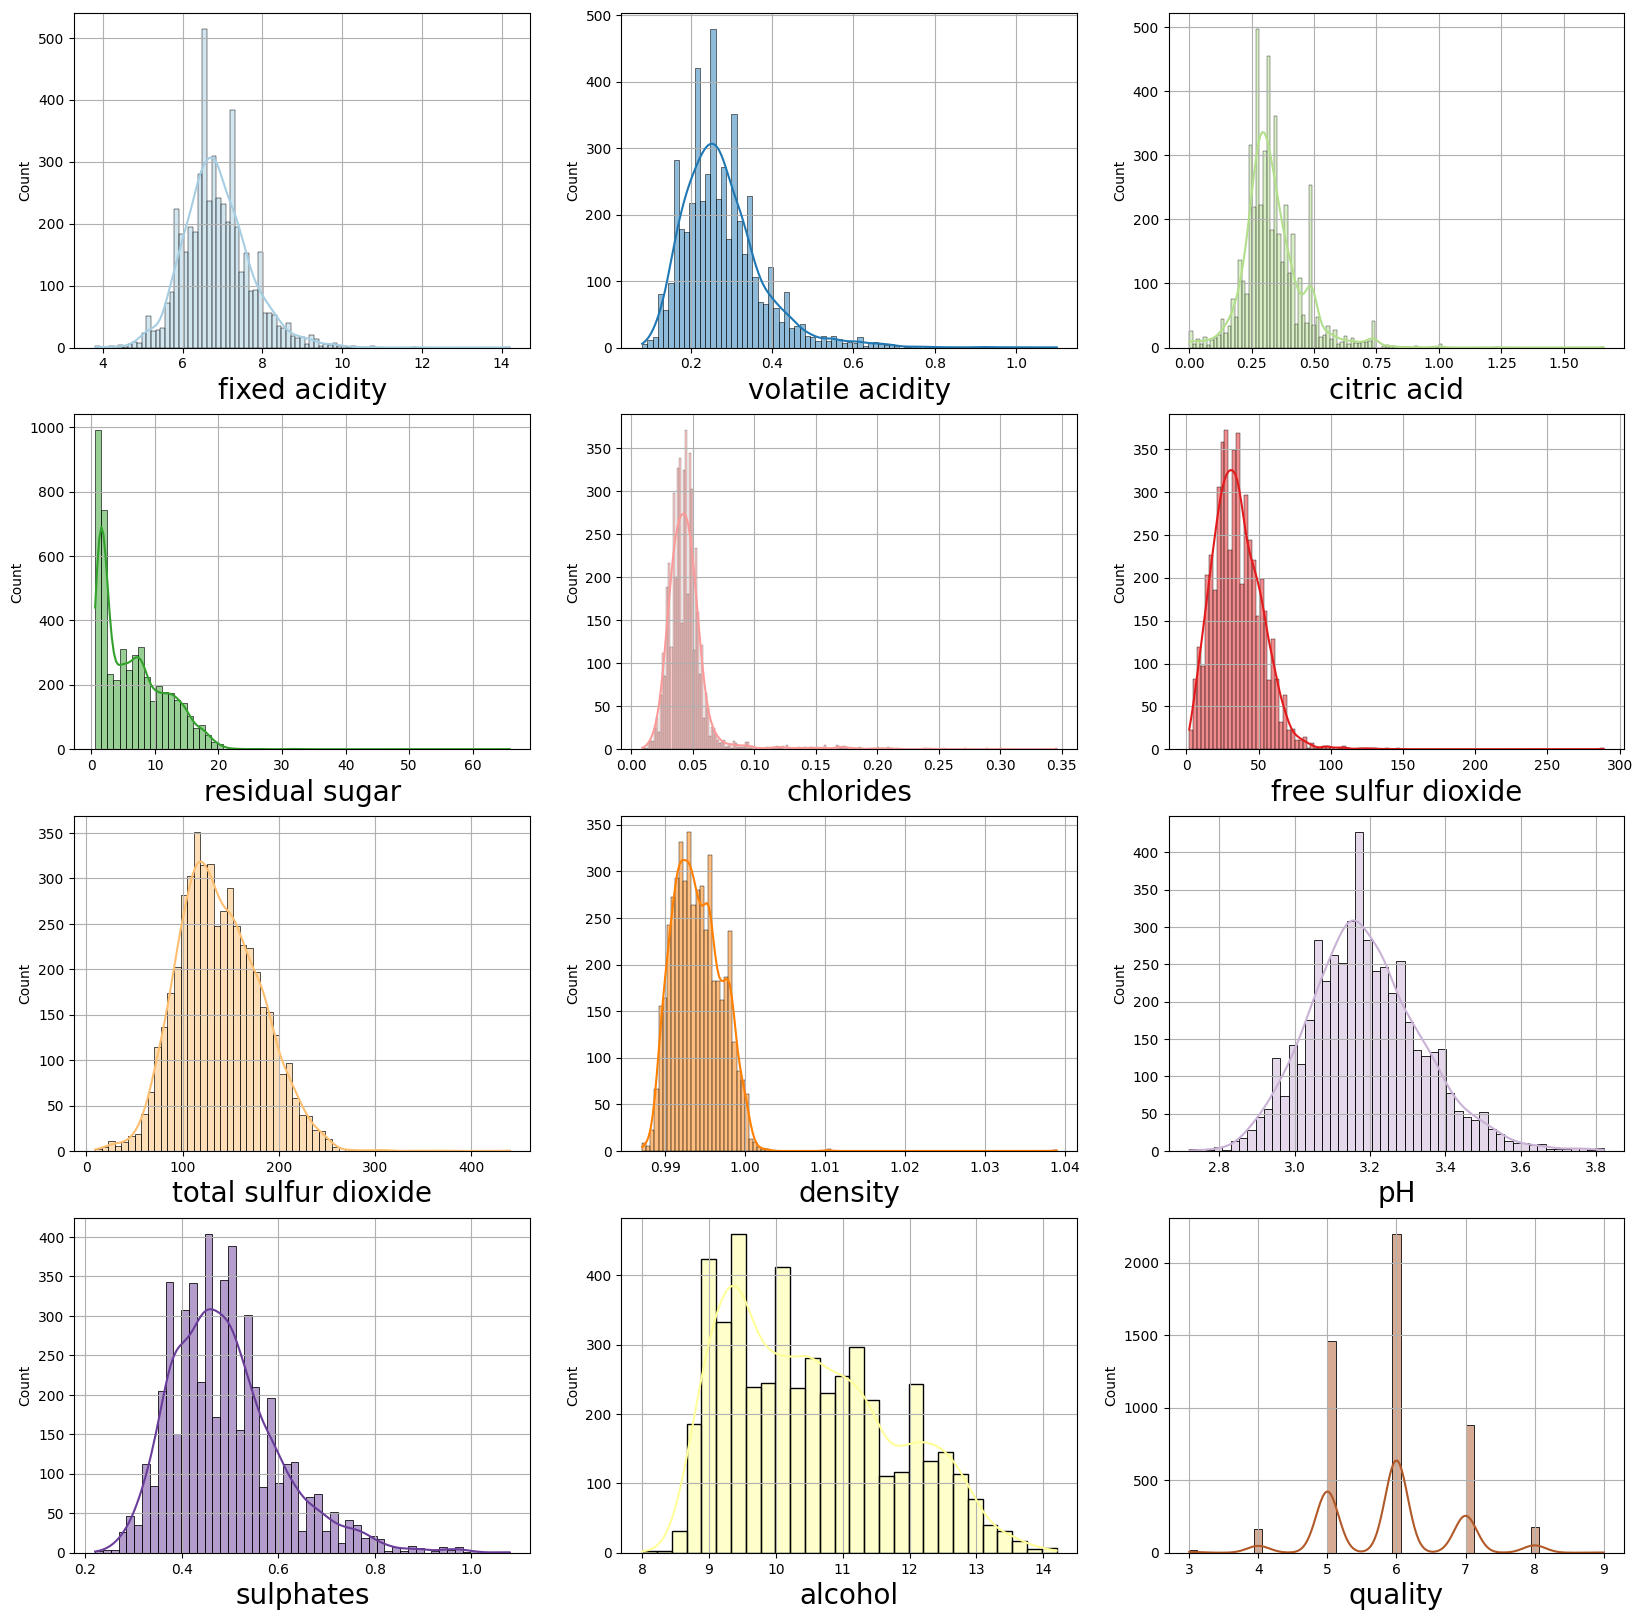

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
data = df_white
col = 0
for i in range(4):
  for j in range(3):
    sns.histplot(data[data.columns[col]], kde = True, ax = axs[i, j], color = cm.Paired(col))
    axs[i, j].set_xlabel(data.columns[col], fontsize = 20)
    col += 1

Распределение признаков для красного и белого вин различно, целесообразно разделить датасет по типу вина.

In [ ]:
df_red_outliners = outliers_LogReg(df_red)
df_white_outliners = outliers_LogReg(df_white)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Строим модель и определяем качество обучения

In [ ]:
model_test(X = df_red_outliners.drop(['quality'], axis = 1), y = df_red_outliners['quality'])

0.6126984126984127

In [ ]:
model_test(X = df_white_outliners.drop(['quality'], axis = 1), y = df_white_outliners['quality'])

0.7151702786377709

In [ ]:
model_test(X = df_red.drop(['quality'], axis = 1), y = df_red['quality'])

0.65625

In [ ]:
model_test(X = df_white.drop(['quality'], axis = 1), y = df_white['quality'])

0.6938775510204082

In [ ]:
model_test(X = df_fillna.drop(['type' ,'quality'], axis = 1), y = df_fillna['quality'])

0.69

Выводы:
1. Качество предсказания оценки вина неочень высокое.
2. Исключение выбросов в среднем неизменило качество моделей (для красного вина качество снизилось, для белого повысилось).
3. Разделение датасета по видам вина незначительно повысило качество модели для белого вина, но снизило для красного.